# Restricted Boltzmann Machines

### Energy-based model
Energy-based models associate a scalar energy to each configuration of the variables of interest. Low energy is more desirable. The probability distribution based on an energy function can be defined as follows
$$ \Pr(x) = \frac{\exp (-E(x))}{Z}\,,$$
where $Z = \sum_{x} \exp (-E(x))$ denotes the normalization factor or **partition function**. 

### Restricted Boltzmann Machine

Restricted Boltzmann Machine (RBM) has an efficient training algorithm. In order to increase the expressive power of the model, we do not observe the example $x$ fully, we also want to introduce some non-observed variables.  Consider an observed part $x$ and a hidden part $h$. We can then write:
$$\Pr(x) = \sum_h \frac{\exp (-E(x, h))}{Z} \,.$$

In RBM, the energy function is defined as
$$
E(x, h) = -a^\top x - b^\top h - x^\top W h \,.
$$

To make RBM as an energy-based model, the free energy function is computed as follows
$$
\begin{align}
F(x) &= -\log \sum_h \exp (-E(x, h)) \\
     &= -a^\top x - \sum_j \log (1 + \exp(W^{\top}_jx + b_j))\,.
\end{align}
$$

We have an tractable expression for the conditional probabilities
$$
\Pr (h|x) = \prod_i \Pr (h_i | x)
$$

In [30]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from rbm import RBM

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

Available device: cuda:0


Make some configurations

In [31]:
batch_size = 64 # batch size
n_epochs = 25 # number of epochs
lr = 0.01 # learning rate
n_hidden = 128 # number of units in the hidden layer
n_visible = 784 # input size

Create a RBM model

In [32]:
# create a Restricted Boltzmann Machine
model = RBM(n_visible, n_hidden, k=1, cuda=True)

CUDA device was selected successfully.
PyTorch target device: cuda:0


Prepare the data set

In [33]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./out', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

Then train the model.

In [34]:
def train(model, train_loader, input_size, n_epochs=n_epochs):
    for epoch in range(n_epochs):
        epoch_error = 0.0

        for batch, _ in train_loader:
            batch = batch.view(-1, input_size)  # flatten input data
            batch = batch.to(device)
            batch_error = model.contrastive_divergence(batch)
            epoch_error += batch_error

        print(f'Epoch: {epoch + 1} | Error: {epoch_error:.4f}')
    return model

In [35]:
model = train(model, train_loader, n_visible, n_epochs=n_epochs)

Epoch: 1 | Error: 97.9001
Epoch: 2 | Error: 64.1085
Epoch: 3 | Error: 52.9415
Epoch: 4 | Error: 47.0880
Epoch: 5 | Error: 43.8372
Epoch: 6 | Error: 41.5832
Epoch: 7 | Error: 39.9684
Epoch: 8 | Error: 38.7417
Epoch: 9 | Error: 37.6557
Epoch: 10 | Error: 36.6814
Epoch: 11 | Error: 35.7948
Epoch: 12 | Error: 35.0488
Epoch: 13 | Error: 34.4137
Epoch: 14 | Error: 33.8698
Epoch: 15 | Error: 33.3766
Epoch: 16 | Error: 32.9624
Epoch: 17 | Error: 32.5494
Epoch: 18 | Error: 32.1709
Epoch: 19 | Error: 31.7928
Epoch: 20 | Error: 31.5103
Epoch: 21 | Error: 31.2001
Epoch: 22 | Error: 30.9243
Epoch: 23 | Error: 30.6535
Epoch: 24 | Error: 30.4295
Epoch: 25 | Error: 30.2275


In [36]:
images = next(iter(train_loader))[0]
v, v_rec = model.forward(images.to(device).view(-1, 784), train=False)

In [37]:
# show the real images
def show_and_save(img, file_name):
    r"""Show and save the image.

    Args:
        img (Tensor): The image.
        file_name (Str): The destination.

    """
    npimg = np.transpose(img.to('cpu').numpy(), (1, 2, 0))
    f = "./%s.png" % file_name
    plt.imshow(npimg, cmap='gray')
    plt.imsave(f, npimg)

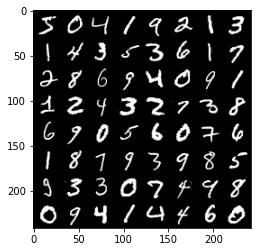

In [38]:
show_and_save(make_grid(v.view(batch_size, 1, 28, 28).data), 'out/real')

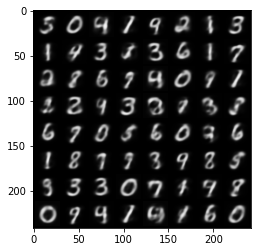

In [39]:
# show the generated images
show_and_save(make_grid(v_rec.view(batch_size, 1, 28, 28).data), 'out/generated')

How one image is factorized through the hidden variables

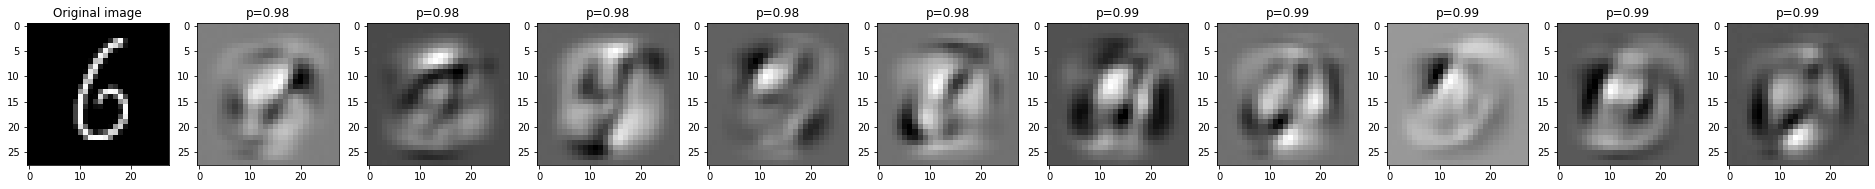

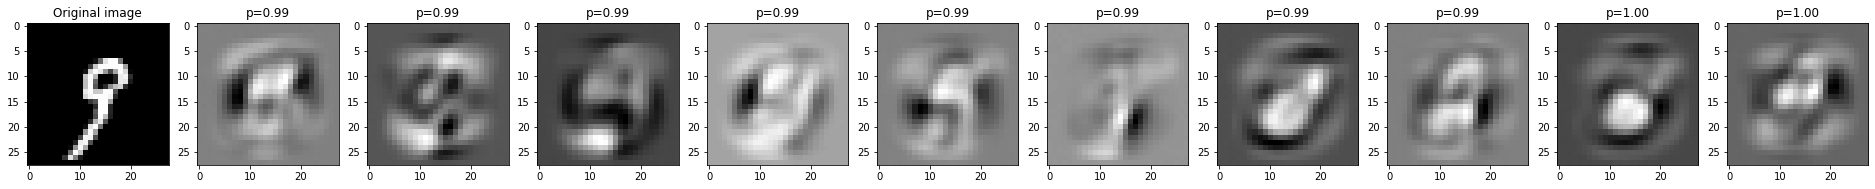

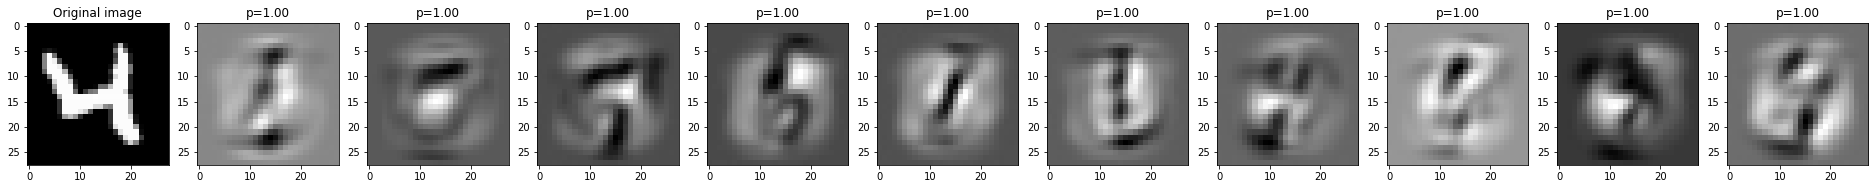

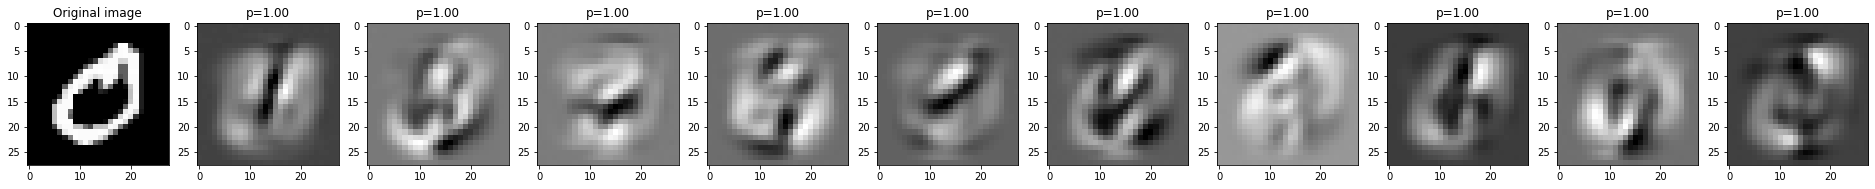

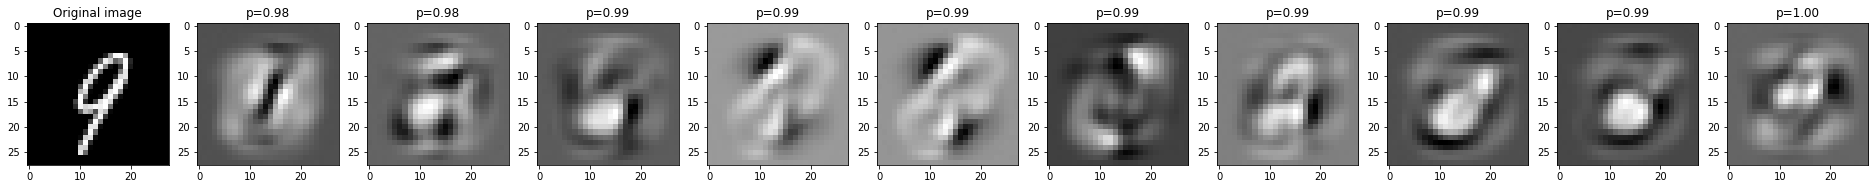

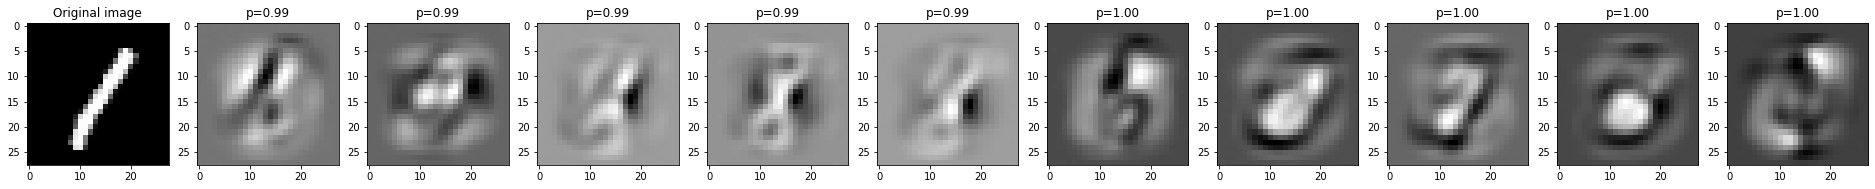

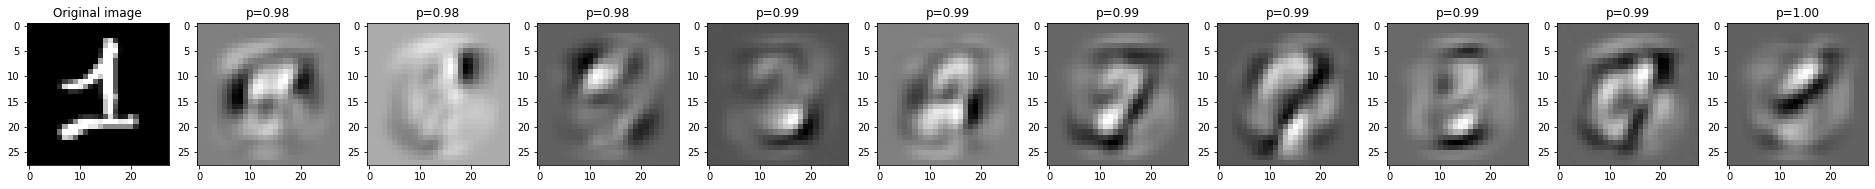

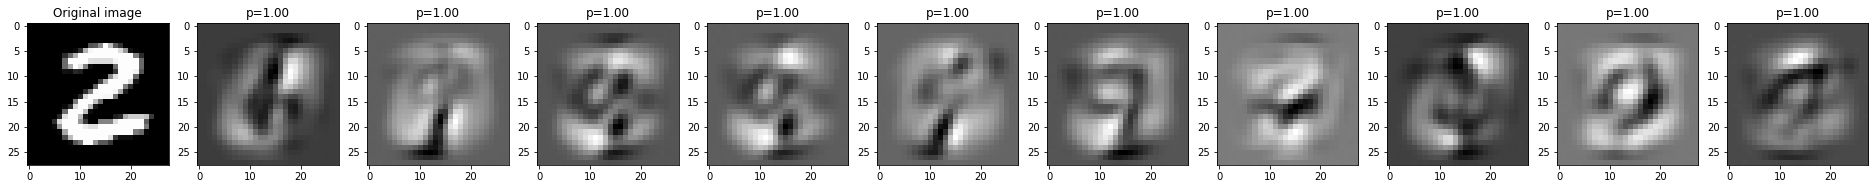

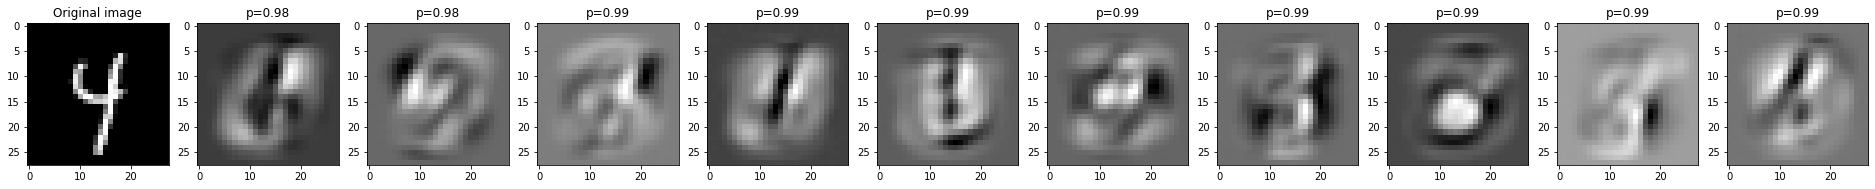

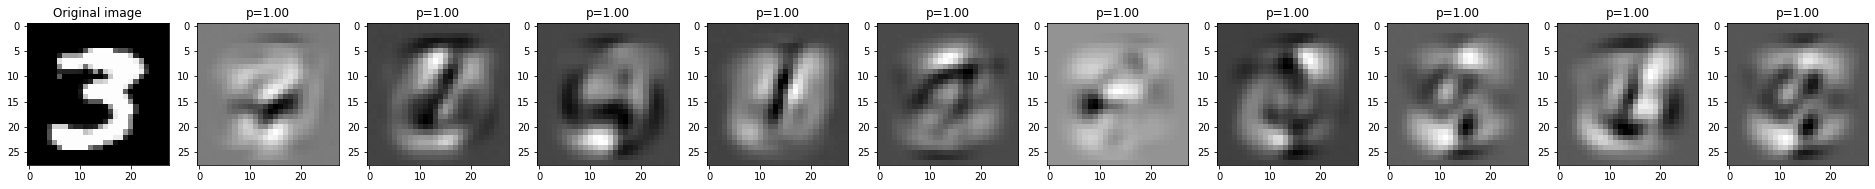

In [21]:
for j in range(18, 28):
    n_sample = 10
    d = images[j:j+1]

    V = torch.sigmoid(F.linear(d.view(1, -1), model.weights.to('cpu').t(), model.h_bias.to('cpu')))
    v, o = torch.sort(V.view(-1))

    fig, ax = plt.subplots(1, n_sample + 1, figsize=(3*(1 + n_sample),3))
    ax[0].imshow(d.view(28, 28).numpy(), cmap='gray')
    ax[0].set_title('Original image')

    for k, i in enumerate(o[-n_sample:].numpy()):
        weights_i = model.weights.t()[i].to('cpu')
        f = weights_i.view(28, 28).data.numpy()
        ax[k + 1].imshow(f, cmap='gray')
        ax[k + 1].set_title('p=%.2f'% V[0][i].item())

    plt.savefig(f'out/factor_{j}.png', dpi=150)